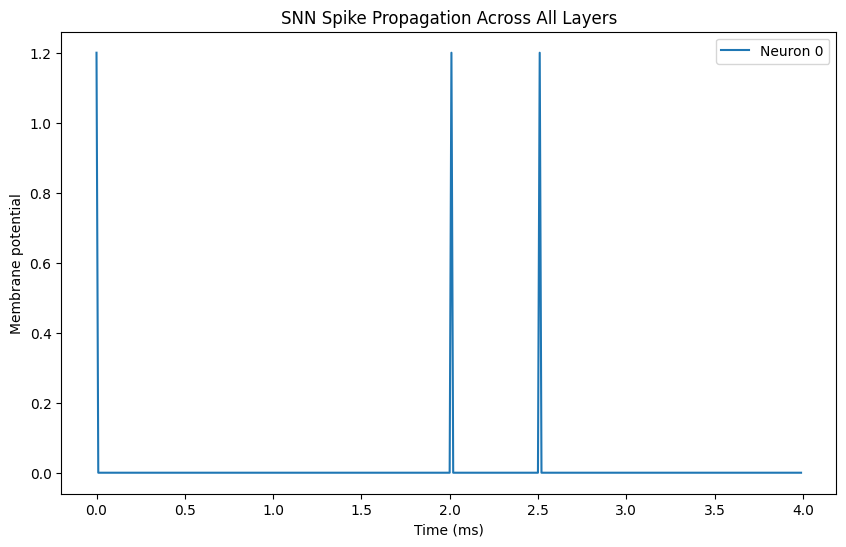

Neuron 0 spike times: ['0.000 ms', '2.010 ms', '2.510 ms']


In [3]:
# V0.1 Single Neruon for Yggrasil for spiking inputs and tau

from brian2 import *
import numpy as np
import logging, warnings

start_scope()

defaultclock.dt = 0.01*ms  

#prefs.codegen.target = 'cython'
set_device('runtime')
warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
np.seterr(over='ignore', under='ignore')
logging.getLogger('brian2').setLevel(logging.ERROR)



@implementation('numpy', discard_units=True)
@check_units(global_clock=1, input_fired=1, tau = 1, spikes_fired=1, result=1)
def tau_fire(spikes_fired, input_fired,tau, global_clock):
    '''0 when not at tau time + fired_time 1 when it is v +=1.2 when it is true'''
    if spikes_fired == 2: 
        if global_clock > input_fired + tau - 0.01:  # can change the - to other value of time_steps
            return 1
    return 0


neurons = NeuronGroup(1, '''
        v : 1
        tau : 1
        global_clock : 1
        spikes_fired : 1
        input_fired : 1
    ''', threshold='v > 1', reset='''
        v = 0
        spikes_fired += 1
    ''', method='exact') 
neurons.v = 1.2
neurons.tau = 0.5
neurons.spikes_fired = 0
neurons.input_fired = 4 # should be runtime to start 




stim = SpikeGeneratorGroup(1, indices=[0], times=[2.0] * ms)


syn_input = Synapses(stim, neurons[0:1], '''
''', on_pre='''
    v += 1.2
    input_fired = global_clock
''')
syn_input.connect(j='i')  # connects linears 1-1 2-2 ect


neurons.run_regularly('''
    v += (tau_fire(spikes_fired, input_fired, tau, global_clock) * 1.2)

    global_clock += 0.01
''', dt=0.01*ms)

mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
spikemon = SpikeMonitor(neurons)

run(4*ms)

    # Plot voltages
figure(figsize=(10, 6))
for i in range(1):  # All neurons
    plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane potential')
legend()
title('SNN Spike Propagation Across All Layers')
show()

for i in range(1):
    times = spikemon.spike_trains()[i]
    if len(times) > 0:
        formatted_times = [f"{t/ms:.3f} ms" for t in times]
        print(f"Neuron {i} spike times: {formatted_times}")
